# Redes convolucionales
En este ejercicio utilizaremos el datasets de clasificación [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) que consiste de 60,000 imagenes a color de 32x32 pixeles y 10 clases distintas. Este conjunto de datos se encuentra directamente integrado en torchvision por lo que no es necesario descargar algún archivo adicional.

Los datasets de torchvision están conformados por imágenes en formato PILImage que tienen rango [0, 1], le aplicaremos una transformación para convertirlos a tensor y luego aplicaremos una normalización para convertirlas al rango [-1, 1] ya que usualmente las redes neuronales convolucionales funcionan mejor con entradas que cumplen estas características.

Para entregar tu tarea, intenta mejorar el accuracy de validación hasta que llegue a un mínimo de 70%

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

# TODO: Agrega transformaciones (data augmentation) si así lo deseas
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

## Parte 1 - Análisis de datos
Este dataset contiene las clases: avión, carro, ave, gato, venado, perro, rana, caballo, bote, camión. A continuación se muestran algunas imágenes de ejemplo

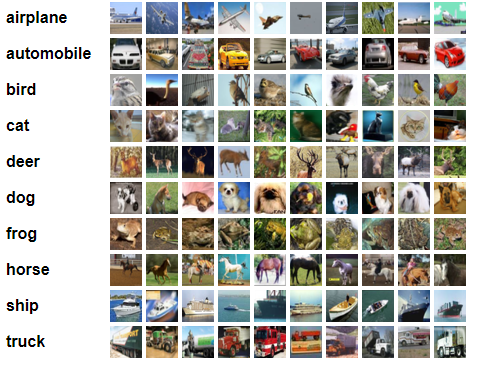

En la siguiente celda, instanciamos el dataset y Dataloader para poder transformar e iterar los datos.

In [6]:
# TODO: Modifica el batch_size a tu gusto
batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data',
                                        train=True,
                                        download=True,
                                        transform=transform)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data',
                                       train=False,
                                       download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=2)

# avión es clase 0, 1 <- carro y así sucesivamente
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Comencemos visualizando las imágenes de entrenamiento junto con sus etiquetas

torch.Size([16, 3, 32, 32]) torch.Size([16])
(3, 70, 274)


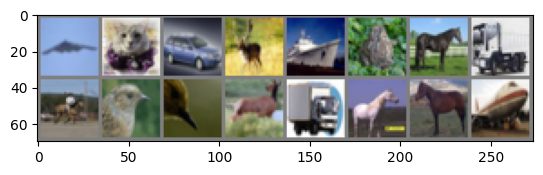

plane cat   car   deer  ship  frog  horse truck horse bird  bird  deer  truck horse horse plane


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize [-1, 1] -> [0, 1]
    npimg = img.numpy()     # Tensor to numpy
    print(npimg.shape)      # 3, H, W
    # imshow expects the channels at the end
    pltimg = np.transpose(npimg, (1, 2, 0)) # C, H, W -> H, W, C
    plt.imshow(pltimg) 
    plt.show()


# get some random training images
dataiter = iter(trainloader)    # Make trainloader iterable
images, labels = next(dataiter) # Take one batch
print(images.shape, labels.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 2. Definiendo nuestra CNN

En la siguiente sección, definirás tu red neuronal puedes diseñarla como gustes! Recuerda tener en cuenta lo siguiente:
- Dado que estamos trabajando con imágenes a color, tendremos 3 canales de entrada.
- El objetivo es clasificar una imagen dentro de las 10 clases posibles.
    - ¿Cuantas neuronas necesitamos en la última capa?
    - ¿Qué función de activación deberíamos usar en la última capa?
    - ¿Cuál función de costo deberíamos usar para la función de activación anterior?
- Para poder propagar la salida de una capa convolucional por una capa lineal, necesitamos transformar la imagen de nuevo a forma de vector. Investiga el uso de [nn.Flatten o torch.flatten()](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
in_channels = 3
n_classes = 10
# Input images:  Batch x 3 x 48 x 48
# Torch espera que los canales sean antes: C x H x W
# openCV espera H x W x C

# TODO: Define tu red con nn.Sequential
net = nn.Sequential(
    nn.Conv2d(in_channels, 16, 5),
    nn.ReLU(),
    nn.Conv2d(in_channels = 16, out_channels=32, kernel_size=5),
    nn.ReLU(),
    nn.Conv2d(in_channels = 32, out_channels= 64, kernel_size=5),
    nn.ReLU(),
    nn.Conv2d(in_channels = 64, out_channels= 128, kernel_size=5),
    nn.ReLU(),
    nn.Flatten(start_dim=1), #128 * 32 * 32
    nn.Linear(128 * 16 * 16, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10), #B, 10
)


In [9]:
def calc_out_dims(input_dim, kernel_size, stride=1, padding=0):
    #TODO: implementa la funcion para calcular la dimensionalidad de salida de una cnn
    output_dims = (input_dim - kernel_size + 1)
    return output_dims

output_dims = 32
for kernel_size in [5,5,5]:
    output_dims = calc_out_dims(output_dims, kernel_size)
    print(output_dims)

28
24
20


In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # TODO: define las capas de tu red
        self.conv1 = nn.Conv2d(in_channels, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32, 64, 5)
        self.conv4 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(128 * 16 * 16, 1024)
        self.fc2 = nn.Linear(1024, 10)       


    def forward(self, x):
        # TODO: Define el forward pass de la red
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net2 = Net()
# TODO: imprime la prediccion de images para la red
print(images.shape, labels.shape)
output = net2(images)
print(output.shape)

torch.Size([16, 3, 32, 32]) torch.Size([16])
torch.Size([16, 10])


In [11]:
# Selección de modelo.
net = net2

Antes de entrenar, visualicemos el funcionamiento de nuestra red en los datos de prueba

(3, 70, 274)


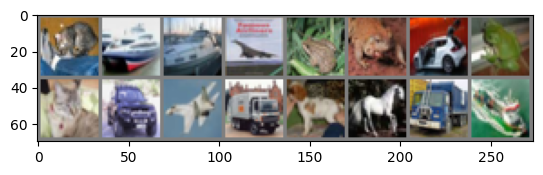

GroundTruth:  cat   ship  ship  plane
Predicted:  deer  deer  deer  deer 


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
# Imprimimos las etiquetas
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Hacemos la predicción
outputs = net(images)
# Tomamos la clase más probable para cada salida
_, predicted = torch.max(outputs, 1)

# Imprimimos las predicciones
print('Predicted: ',
      ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

## 3. Entrenando la red
Contamos con un problema multiclase, por lo que podemos definir utilizar la función de perdida de ["Cross Entropy Loss"](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=cross+entropy#torch.nn.CrossEntropyLoss).
Para optimizar nuestra red utilizaremos descenso de gradiente estocástico.

In [13]:
import torch.optim as optim

# TODO: Define la función de costo (criterion) y el optimizador.
costo_fcn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params = net.parameters(), lr=1e-5)


Al tener el dataset, la red neuronal, la función de perdida y el optimizador definidos, podemos comenzar a optimizar nuestra red con la intención de hacer nuestras predicciones tan similares a las etiquetas del dataset de entrenamiento.

Para ello debemos iterar nuestro dataset de entrenamiento, utilizar los batches como entradas para nuestra red neuronal y optimizarla. De esta manera lograremos encontrar los pesos que minimizan la función de perdida.

In [14]:
# TODO: Modifica la cantidad de epochs que quieres iterar tu conjunto de entrenamiento
n_epochs = 10
for epoch in range(n_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Obtener las entradas; data is una lista de [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # TODO: Define el forward + backward pass + actualización de pesos
        preds = net(inputs)
        loss = costo_fcn(preds, labels)
        loss.backward()
        optimizer.step()
        # imprimir estadísticas
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.849
[2,  2000] loss: 1.574
[3,  2000] loss: 1.470
[4,  2000] loss: 1.407
[5,  2000] loss: 1.352
[6,  2000] loss: 1.309
[7,  2000] loss: 1.274
[8,  2000] loss: 1.232
[9,  2000] loss: 1.203
[10,  2000] loss: 1.167
Finished Training


### 3.1 Guardando el modelo
Nuestro dataset ya ha sido entrenado, ahora podemos guardar los pesos para poder predecir la clase de las imagenes de prueba con ellos en el futuro.

In [15]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### 5. Inferencia
#### 5.1 Probando nuestra red en el dataset de prueba
Vamos a comprobar si nuestra red fue entrenada de manera correcta.
Para ello predeciremos a que clase pertenece cada imagen utilizando la salida. Luego compararemos esta predicción con la verdadera etiqueta. Compara el resultado con las preddiciones que obtuviste antes de entrenar tu red, ¿notas la diferencia?

Antes de hacer esto comenzaremos viendo los datos de prueba para familiarizarnos con él.

(3, 70, 274)


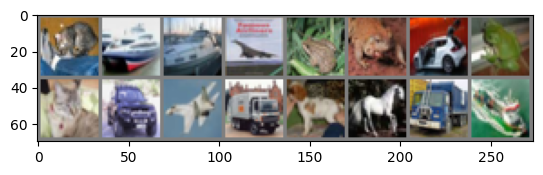

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  car   ship 


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
net = Net()

# Cargaremos los pesos preentrenados
net.load_state_dict(torch.load(PATH))

# Usamos los pesos entrenados para predecir la clase de las imágenes anteriores.
outputs = net(images)
values, predicted = torch.max(outputs, 1)
# predicted = torch.argmax(outputs, 1) # argmax te regresa el índice directamente

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

### 5.2 Dataset de validación
Veamos ahora como funciona nuestra red para todo el dataset.

In [17]:
# Diccionarios para contar la cantidad de predicciones correctas
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0

# En inferencia no necesitamos gradientes
with torch.inference_mode():
    for data in testloader:
        images, labels = data
        # TODO: Realiza el forward pass
        outputs = net(images)
        
        # TODO: para cada salida de la red, indica la clase (0,1,...,6)
        _, preds = torch.max(outputs, 1)
        # Calculando predicciones correctas (TOTAL)
        total += labels.size(0)
        cor = (preds == labels).sum().item()
        correct += cor

        # Predicciones correctas por CLASE
        for label, prediction in zip(labels, preds):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# Imprimir el accuracy por cada clase
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy por clase: {classname:5s} is {accuracy:.1f} %')
print(f'Accuracy de la red en las 1000 imágenes de entrenamiento: {(100 * correct / total):.1f} %')

Accuracy por clase: plane is 60.1 %
Accuracy por clase: car   is 70.1 %
Accuracy por clase: bird  is 37.3 %
Accuracy por clase: cat   is 32.1 %
Accuracy por clase: deer  is 30.9 %
Accuracy por clase: dog   is 54.5 %
Accuracy por clase: frog  is 75.9 %
Accuracy por clase: horse is 67.6 %
Accuracy por clase: ship  is 77.0 %
Accuracy por clase: truck is 66.3 %
Accuracy de la red en las 1000 imágenes de entrenamiento: 57.2 %
